In [38]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

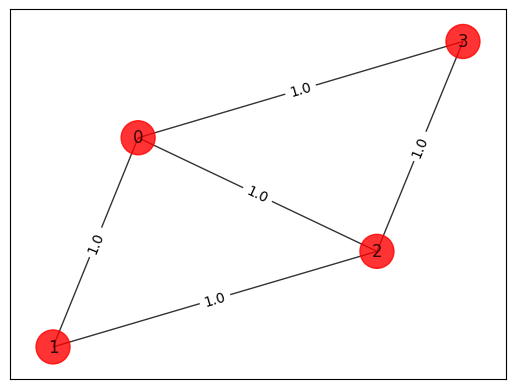

In [41]:
# Our Graph
n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [42]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)


[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


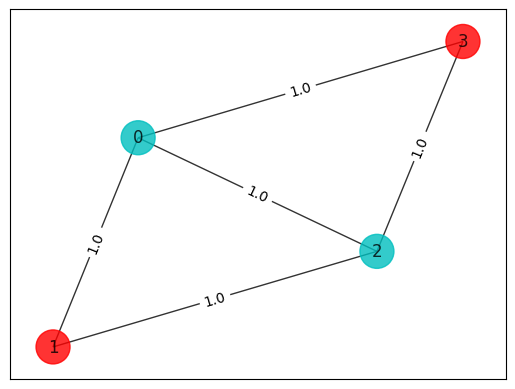

In [44]:
# Brute Force
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

In [45]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())


Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [46]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.5
Ising Hamiltonian:
SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [47]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


energy: -1.5
max-cut objective: -4.0
solution: [1. 0. 1. 0.]
solution objective: 4.0


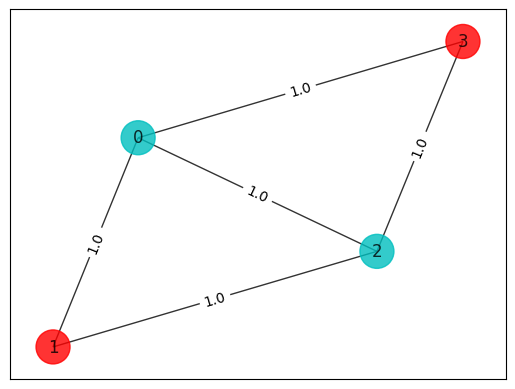

In [48]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

In [49]:
algorithm_globals.random_seed = 123
seed = 10598


/var/folders/f2/1pdrg9dj61sfwvq821_v85zr0000gn/T/ipykernel_23884/639890245.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)


energy: -1.49968614555873
time: 0.8002481460571289
max-cut objective: -3.99968614555873
solution: [0 1 0 1]
solution objective: 4.0


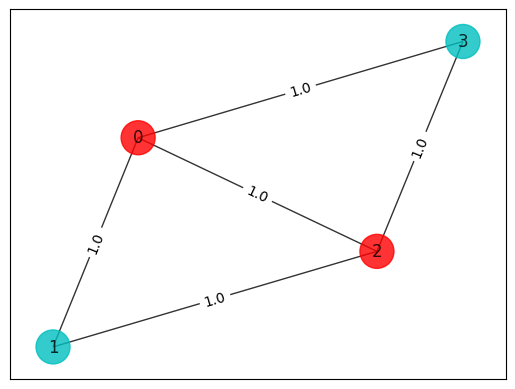

In [50]:
# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


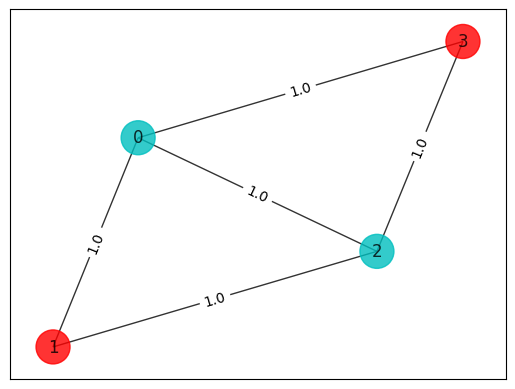

In [51]:
# create minimum eigen optimizer based on SamplingVQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)